# Modeling dynamical systems on networks in Julia

This notebook showcases how to define dynamical systems supported on networks using three different methods.

In [1]:
using LinearAlgebra
using Graphs
using DifferentialEquations
using ModelingToolkit
using NetworkDynamics
using Random
using Symbolics: scalarize
using BenchmarkTools
using Plots
using StatsPlots

In [2]:
# Set the seed for reproducibility
Random.seed!(2023)

TaskLocalRNG()

Set the values of all the parameters in advance

In [3]:
N = 5
g = watts_strogatz(N, 4, 0.4)
u0 = rand(N,2)
a_ = 1.0
b_ = 3.0
L_ = float.(laplacian_matrix(g)) # avoid converting to floats in the odefuns
D_u_ = 0.5
D_v_ = 0.1
tspan = (0.0, 20.0)

(0.0, 20.0)

In [4]:
brusselator_x(x,y,a,b) = a + x^2 * y - b*x -x
brusselator_y(x,y,a,b) = b*x - x^2 * y

brusselator_y (generic function with 1 method)

## Approach 1: Hand-crafted functions

We start by defining an in-place function for the base Brusselator system, which can then reuse.

In [5]:
function brusselator!(dx, x, p, t)
    a, b = p
    dx[1] = brusselator_x(x[1], x[2], a, b)
    dx[2] = brusselator_y(x[1], x[2], a, b)
end

brusselator! (generic function with 1 method)

Notice the use of `@views` to ensure the arrays are updated as they should.

In [6]:
function brusselator_rd!(du, u, p, t)
    p_b, L, D = p
    @views for i in axes(du, 1)
        brusselator!(du[i,:], u[i,:], p_b, t)
    end
    @views begin
        mul!(du[:,1], L, u[:,1], -D[1], 1.0) # du[:,1] .-= D[1]*L*u[:,1]
        mul!(du[:,2], L, u[:,2], -D[2], 1.0)
    end
end

brusselator_rd! (generic function with 1 method)

In [7]:
p = ([a_, b_], L_, [D_u_, D_v_]) # Use tuples for type stability!
prob = ODEProblem(brusselator_rd!, u0, tspan, p)
sol = solve(prob, Rodas5())

retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 65-element Vector{Float64}:
  0.0
  0.03460094242359962
  0.07938345763847535
  0.13888757784264028
  0.21311034058692271
  0.30532119370043465
  0.41754422713823924
  0.553828279124587
  0.7193645629542668
  0.9226982062838679
  ⋮
 16.30684070889914
 16.60056084328424
 16.918478760598745
 17.295323916528215
 17.780604893994894
 18.265885871461574
 18.88377596108157
 19.55903402392607
 20.0
u: 65-element Vector{Matrix{Float64}}:
 [0.05798523166511249 0.1383929610938679; 0.5655548397194458 0.3330637780328449; … ; 0.7471957611034997 0.20156081508437584; 0.8245816388488778 0.7819248287604422]
 [0.1108606172310568 0.1512472074497721; 0.51943357493187 0.38593424631375706; … ; 0.6648730591413505 0.27302105146315403; 0.7382649033270772 0.83832309652095]
 [0.16174953125685393 0.17539484929373944; 0.4709641080262513 0.4478568395521454; … ; 0.580405278536153 0.35341695535704215; 0.646650705467598 0.9024

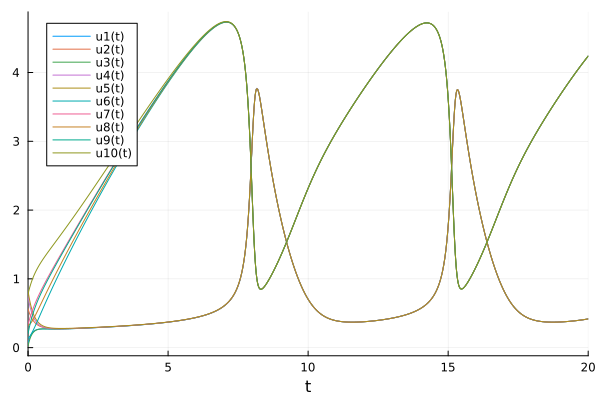

In [8]:
plot(sol)

## Approach 2: ModelingToolkit

This approach consists in defining the equations of the model symbolically, and then generating optimized ODE functions for it. For example, here is how to define the base Brusselator model.

In [9]:
@parameters t a b
@variables x(t) y(t)
D = Differential(t)

eqs_base = [
    D(x) ~ brusselator_x(x,y,a,b),
    D(y) ~ brusselator_y(x,y,a,b)
]

@named sys_base = ODESystem(eqs_base)


Model sys_base with 2 equations
States (2):
  x(t)
  y(t)
Parameters (2):
  a
  b

For our networked system, we need to use symbolic arrays, which is fairly straightforward in this case. Notice that we need to broadcast the differential.

In [10]:
@parameters t a b L[1:N,1:N] D_u D_v
@variables u(t)[1:N] v(t)[1:N]
D = Differential(t)

dudt = brusselator_x.(u,v,a,b) - D_u * (L * u)
dvdt = brusselator_y.(u,v,a,b) - D_v * (L * v)

eqs = [
    D.(u) ~ dudt;
    D.(v) ~ dvdt
]

@named sys_rd = ODESystem(eqs)

Model sys_rd with 10 equations
States (10):
  (u(t))[1]
  (u(t))[2]
  (u(t))[3]
  (u(t))[4]
⋮
Parameters (29):
  L[1, 2]
  L[1, 5]
  L[1, 1]
  b
⋮

If you were to try and display `eqs` directly, you'd be met with a wall of code instead of nicely rendered equations.

In [11]:
eqs

10-element Vector{Any}:
 (broadcast(~, broadcast(Differential(t), u(t)), broadcast(-, broadcast(brusselator_x, u(t), v(t), Ref(a), Ref(b)), broadcast(*, Ref(D_u), L*u(t)))))[1]
 (broadcast(~, broadcast(Differential(t), u(t)), broadcast(-, broadcast(brusselator_x, u(t), v(t), Ref(a), Ref(b)), broadcast(*, Ref(D_u), L*u(t)))))[2]
 (broadcast(~, broadcast(Differential(t), u(t)), broadcast(-, broadcast(brusselator_x, u(t), v(t), Ref(a), Ref(b)), broadcast(*, Ref(D_u), L*u(t)))))[3]
 (broadcast(~, broadcast(Differential(t), u(t)), broadcast(-, broadcast(brusselator_x, u(t), v(t), Ref(a), Ref(b)), broadcast(*, Ref(D_u), L*u(t)))))[4]
 (broadcast(~, broadcast(Differential(t), u(t)), broadcast(-, broadcast(brusselator_x, u(t), v(t), Ref(a), Ref(b)), broadcast(*, Ref(D_u), L*u(t)))))[5]
 (broadcast(~, broadcast(Differential(t), v(t)), broadcast(-, broadcast(brusselator_y, u(t), v(t), Ref(a), Ref(b)), broadcast(*, Ref(D_v), L*v(t)))))[1]
 (broadcast(~, broadcast(Differential(t), v(t)), broadcast

To fix this, we can use the `Symbolics.scalarize` function, which takes a symbolic array and returns an array of symbolic variables. This function is very useful to debug this kind of models.

In [12]:
scalarize.(eqs)

10-element Vector{Equation}:
 Differential(t)((u(t))[1]) ~ a + ((u(t))[1]^2)*(v(t))[1] - (u(t))[1] - D_u*((u(t))[1]*L[1, 1] + (u(t))[2]*L[1, 2] + (u(t))[3]*L[1, 3] + (u(t))[4]*L[1, 4] + (u(t))[5]*L[1, 5]) - b*(u(t))[1]
 Differential(t)((u(t))[2]) ~ a + ((u(t))[2]^2)*(v(t))[2] - (u(t))[2] - D_u*((u(t))[1]*L[2, 1] + (u(t))[2]*L[2, 2] + (u(t))[3]*L[2, 3] + (u(t))[4]*L[2, 4] + (u(t))[5]*L[2, 5]) - b*(u(t))[2]
 Differential(t)((u(t))[3]) ~ a + ((u(t))[3]^2)*(v(t))[3] - (u(t))[3] - D_u*((u(t))[1]*L[3, 1] + (u(t))[2]*L[3, 2] + (u(t))[3]*L[3, 3] + (u(t))[4]*L[3, 4] + (u(t))[5]*L[3, 5]) - b*(u(t))[3]
 Differential(t)((u(t))[4]) ~ a + ((u(t))[4]^2)*(v(t))[4] - (u(t))[4] - D_u*((u(t))[1]*L[4, 1] + (u(t))[2]*L[4, 2] + (u(t))[3]*L[4, 3] + (u(t))[4]*L[4, 4] + (u(t))[5]*L[4, 5]) - b*(u(t))[4]
 Differential(t)((u(t))[5]) ~ a + ((u(t))[5]^2)*(v(t))[5] - (u(t))[5] - D_u*((u(t))[1]*L[5, 1] + (u(t))[2]*L[5, 2] + (u(t))[3]*L[5, 3] + (u(t))[4]*L[5, 4] + (u(t))[5]*L[5, 5]) - b*(u(t))[5]
 Differential(t)((v(t

In [13]:
p_mt = [
    a => a_,
    b => b_,
    collect(L .=> L_)...,
    #L => L_, # This apparently doesn't work
    D_u => D_u_,
    D_v => D_v_
]
u0_mt = [
    collect(u .=> u0[:,1]);
    collect(v .=> u0[:,2])
]
prob_mt = ODEProblem(sys_rd, u0_mt, tspan, p_mt)
sol_mt = solve(prob_mt, Rodas5())

retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 65-element Vector{Float64}:
  0.0
  0.03460094242359968
  0.07938345763847547
  0.1388875778426405
  0.21311034058692305
  0.3053211937004351
  0.4175442271382399
  0.5538282791245878
  0.7193645629542678
  0.9226982062838691
  ⋮
 16.306840708899156
 16.600560843284253
 16.91847876059876
 17.29532391652823
 17.78060489399491
 18.265885871461588
 18.883775961081586
 19.559034023926085
 20.0
u: 65-element Vector{Vector{Float64}}:
 [0.05798523166511249, 0.5655548397194458, 0.02297202215918681, 0.7471957611034997, 0.8245816388488778, 0.1383929610938679, 0.3330637780328449, 0.32532350864173976, 0.20156081508437584, 0.7819248287604422]
 [0.11086061723105697, 0.5194335749318703, 0.08289872711051241, 0.6648730591413501, 0.7382649033270771, 0.1512472074497721, 0.38593424631375695, 0.3317467689139132, 0.2730210514631543, 0.8383230965209498]
 [0.16174953125685432, 0.4709641080262515, 0.1409031405121173, 

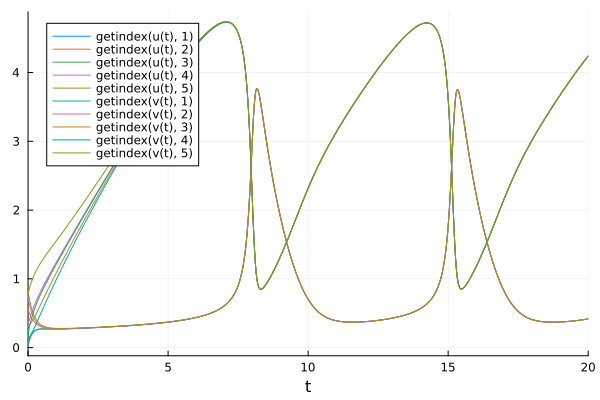

In [14]:
plot(sol_mt)

In order to avoid unfolding dense matmuls, we can just use the laplacian matrix directly in the equations instead of a symbolic variable. This will effectively tailor the generated system to the specific graph we're using.

In [15]:
@parameters t a b D_u D_v
@variables u(t)[1:N] v(t)[1:N]
D = Differential(t)

dudt = brusselator_x.(u,v,a,b) - D_u * (L_ * u)
dvdt = brusselator_y.(u,v,a,b) - D_v * (L_ * v)

eqs_2 = [
    D.(u) ~ dudt;
    D.(v) ~ dvdt
]

@named sys_rd_2 = ODESystem(eqs_2)

Model sys_rd_2 with 10 equations
States (10):
  (u(t))[1]
  (u(t))[2]
  (u(t))[3]
  (u(t))[4]
⋮
Parameters (4):
  a
  D_u
  b
  D_v

In [16]:
p_mt_2 = [
    a => a_,
    b => b_,
    D_u => D_u_,
    D_v => D_v_
]
u0_mt = [
    collect(u .=> u0[:,1]);
    collect(v .=> u0[:,2])
]
prob_mt_2 = ODEProblem(sys_rd, u0_mt, tspan, p_mt)
sol_mt_2 = solve(prob_mt, Rodas5())

retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 65-element Vector{Float64}:
  0.0
  0.03460094242359968
  0.07938345763847547
  0.1388875778426405
  0.21311034058692305
  0.3053211937004351
  0.4175442271382399
  0.5538282791245878
  0.7193645629542678
  0.9226982062838691
  ⋮
 16.306840708899156
 16.600560843284253
 16.91847876059876
 17.29532391652823
 17.78060489399491
 18.265885871461588
 18.883775961081586
 19.559034023926085
 20.0
u: 65-element Vector{Vector{Float64}}:
 [0.05798523166511249, 0.5655548397194458, 0.02297202215918681, 0.7471957611034997, 0.8245816388488778, 0.1383929610938679, 0.3330637780328449, 0.32532350864173976, 0.20156081508437584, 0.7819248287604422]
 [0.11086061723105697, 0.5194335749318703, 0.08289872711051241, 0.6648730591413501, 0.7382649033270771, 0.1512472074497721, 0.38593424631375695, 0.3317467689139132, 0.2730210514631543, 0.8383230965209498]
 [0.16174953125685432, 0.4709641080262515, 0.1409031405121173, 

## Approach 3: NetworkDynamics
This last method is specifically tailored for dynamical systems on networks, and takes a function for the vertex dynamics, and another for the edge dynamics.

In [17]:
function rd_edge!(e, v_s, v_d, p, t)
    e .= v_s .- v_d
    nothing
end

rd_edge! (generic function with 1 method)

In [18]:
function rd_vertex!(dv, v, edges, p, t)
    p_b, D = p
    brusselator!(dv, v, p_b, t)
    for e in edges
        dv .+= D .* e
    end
    nothing
end

rd_vertex! (generic function with 1 method)

Those functions are then passed to the appropriate constructors. Notice the `coupling = :antisymmetric` which lets NetworkDynamics do some optimizations. The result of the final line is an in-place ODE function.

In [19]:
nd_rd_vertex = ODEVertex(; f=rd_vertex!, dim=2)
nd_rd_edge = StaticEdge(; f=rd_edge!, dim=2, coupling=:antisymmetric)

nd_rd! = network_dynamics(nd_rd_vertex, nd_rd_edge, g)

(::ODEFunction{true, SciMLBase.FullSpecialize, NetworkDynamics.NetworkDE{SimpleGraph{Int64}, NetworkDynamics.GraphDataBuffer{Vector{Float64}, Vector{Float64}}, Float64, Float64, Vector{ODEVertex{typeof(rd_vertex!)}}, Vector{StaticEdge{NetworkDynamics.var"#16#25"{typeof(rd_edge!), Int64}}}}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Vector{Symbol}, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}) (generic function with 1 method)

In [20]:
p_nd = (([a_,b_], [D_u_, D_v_]), nothing)
prob_nd = ODEProblem(nd_rd!, vec(u0), tspan, p_nd)
sol_nd = solve(prob_nd, Rodas5())

retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 64-element Vector{Float64}:
  0.0
  0.036751493673528535
  0.08523137390635256
  0.14949385343652322
  0.22970917960528983
  0.3289552918818111
  0.4493744136220686
  0.5953524406921011
  0.7732945539192597
  0.9941663778151905
  ⋮
 16.16010691817525
 16.41250689541876
 16.762331083682387
 17.112155271946015
 17.736779113826763
 18.118775796315138
 18.75601825342599
 19.39326071053684
 20.0
u: 64-element Vector{Vector{Float64}}:
 [0.05798523166511249, 0.5655548397194458, 0.02297202215918681, 0.7471957611034997, 0.8245816388488778, 0.1383929610938679, 0.3330637780328449, 0.32532350864173976, 0.20156081508437584, 0.7819248287604422]
 [0.10184961119034726, 0.5735468684451045, 0.07421724080304785, 0.7485417357664825, 0.7088931376950353, 0.2251021651032851, 0.31954532383215456, 0.3632799016019297, 0.2159221260847965, 0.7988618346362272]
 [0.14559061149265598, 0.5907751551807537, 0.12537429207748887

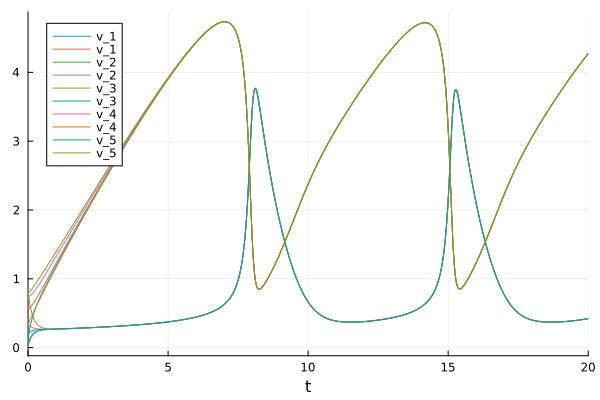

In [21]:
plot(sol_nd)

Variant of NetworkDynamics using `@propagate_inbounds`:

In [22]:
Base.@propagate_inbounds function rd_edge_ib!(e, v_s, v_d, p, t)
    e .= v_s .- v_d
    nothing
end

rd_edge_ib! (generic function with 1 method)

In [23]:
Base.@propagate_inbounds function rd_vertex_ib!(dv, v, edges, p, t)
    p_b, D = p
    brusselator!(dv, v, p_b, t)
    for e in edges
        dv .+= D .* e
    end
    nothing
end

rd_vertex_ib! (generic function with 1 method)

In [24]:
nd_rd_vertex_ib = ODEVertex(; f=rd_vertex_ib!, dim=2)
nd_rd_edge_ib = StaticEdge(; f=rd_edge_ib!, dim=2, coupling=:antisymmetric)

nd_rd_ib! = network_dynamics(nd_rd_vertex_ib, nd_rd_edge_ib, g)

(::ODEFunction{true, SciMLBase.FullSpecialize, NetworkDynamics.NetworkDE{SimpleGraph{Int64}, NetworkDynamics.GraphDataBuffer{Vector{Float64}, Vector{Float64}}, Float64, Float64, Vector{ODEVertex{typeof(rd_vertex_ib!)}}, Vector{StaticEdge{NetworkDynamics.var"#16#25"{typeof(rd_edge_ib!), Int64}}}}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Vector{Symbol}, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}) (generic function with 1 method)

## Benchmarks
Let's benchmark the various ODE functions we obtained. Starting with the base Brusselator functions.

In [25]:
@benchmark brusselator_x(0.5,0.5,1.0,3.0)
@benchmark brusselator_y(0.5,0.5,1.0,3.0)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  0.860 ns … 16.521 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     0.994 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.023 ns ±  0.276 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▆▃       ▁█▄  ▃      ▂                          ▂▂▂▁  ▁▁   ▁
  ██▄▁▁▁▁▁▃███▄▃█▇█▄▄▁▄█▃▁▁▃▃▁▁▄▃▁▃▄▃▁▄▁▁▃▁▄▄▁▄▃▃▁██████████ █
  0.86 ns      Histogram: log(frequency) by time      1.6 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

For some reason, the `brusselator!` function allocates 16 bytes of memory, and I couldn't figure out how to get rid of it. If anyone has any ideas...

In [26]:
dx = zeros(2)
x = zeros(2)
p_b = (a_, b_)
@benchmark brusselator!(dx, x, p_b, 0.0)

BenchmarkTools.Trial: 10000 samples with 998 evaluations.
 Range (min … max):  14.615 ns …   7.823 μs  ┊ GC (min … max): 0.00% … 98.64%
 Time  (median):     17.086 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.920 ns ± 122.415 ns  ┊ GC (mean ± σ):  9.99% ±  1.71%

  ▆▄ ▂▇█▅▄▃▂▃▅▄▄▃▁▁▁▁▁▁ ▁                                      ▂
  █████████████████████████████▇▇▇▇▇▆▆▇▆▅▅▆▆▄▅▅▅▄▅▄▅▅▃▅▄▅▅▅▃▄▅ █
  14.6 ns       Histogram: log(frequency) by time      42.5 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.

Below I compare the performance of `brusselator_rd!` when using a sparse or dense matrix for `L`. They're about the same in terms of speed, but the dense one allocates more memory. (again, I couldn't get rid of them all, and there's clearly more than the ones from `brusselator!`)

In [27]:
du = similar(u0)
b_sparse = @benchmark brusselator_rd!(du, u0, p, 0.0)

BenchmarkTools.Trial: 10000 samples with 960 evaluations.
 Range (min … max):   86.115 ns …  14.985 μs  ┊ GC (min … max):  0.00% … 99.07%
 Time  (median):     100.552 ns               ┊ GC (median):     0.00%
 Time  (mean ± σ):   116.636 ns ± 411.950 ns  ┊ GC (mean ± σ):  10.98% ±  3.12%

  ▃▆▇▃▂▂▂▂█▇▅▄▄▃▃▃▃▂▂▂▁▁ ▁                                      ▂
  ██████████████████████████▇███▇▇▇▇▆▆▆▇▇▇▇▇▇▅▇▇▆▆▇▆▇▆▆▅▅▅▆▆▅▆▅ █
  86.1 ns       Histogram: log(frequency) by time        185 ns <

 Memory estimate: 48 bytes, allocs estimate: 1.

In [28]:
p_dense = ([a_,b_], Array(L_), [D_u_,D_v_])
b_dense = @benchmark brusselator_rd!(du, u0, p_dense, 0.0)

BenchmarkTools.Trial: 10000 samples with 927 evaluations.
 Range (min … max):  110.594 ns …  20.381 μs  ┊ GC (min … max): 0.00% … 99.09%
 Time  (median):     126.203 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   151.498 ns ± 468.758 ns  ┊ GC (mean ± σ):  9.10% ±  2.95%

  ▆▃▁  ▇█▆▄▃▃▃▂▂▂▁▁▁▁                                           ▂
  ████████████████████████▇███▆▇▇▇▆▇▇▇▇▇█▇▇▇▇███▇█▇▇████▇▆▆▇█▆▇ █
  111 ns        Histogram: log(frequency) by time        261 ns <

 Memory estimate: 48 bytes, allocs estimate: 1.

To get the ODE function from the ModelingToolkit model, we just pass it to `ODEFunction`. Unlike the system however, this takes flat vectors for the states and parameters.

In [29]:
f! = ODEFunction{true}(sys_rd) # the true is to get an in-place function
f_2! = ODEFunction{true}(sys_rd_2)
u_vec = vec(u0)
du_vec = similar(u_vec)
p_ = [p.second for p in p_mt];
p_2 = [p.second for p in p_mt_2]

4-element Vector{Float64}:
 1.0
 3.0
 0.5
 0.1

As we can see, it's hands down better than the hand-crafted functions in this case.

In [30]:
b_mt = @benchmark f!(du_vec, u_vec, p_, 0.0)

BenchmarkTools.Trial: 10000 samples with 842 evaluations.
 Range (min … max):  144.977 ns …  15.930 μs  ┊ GC (min … max): 0.00% … 98.47%
 Time  (median):     168.170 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   181.313 ns ± 294.730 ns  ┊ GC (mean ± σ):  3.55% ±  2.20%

  ▅▅▄▂▂  ▁▂█▄▃▄▃▂▂▂▂▁ ▁▁                                        ▁
  █████████████████████████████▇▇▇█▇▇██▇▇▇▇▆▇▆▆▆▆▅▅▆▆▇▆▆▆▆▆▆▅▅▆ █
  145 ns        Histogram: log(frequency) by time        293 ns <

 Memory estimate: 32 bytes, allocs estimate: 1.

In [31]:
b_mt_2 = @benchmark f_2!(du_vec, u_vec, p_2, 0.0)

BenchmarkTools.Trial: 10000 samples with 818 evaluations.
 Range (min … max):  151.346 ns …  15.378 μs  ┊ GC (min … max): 0.00% … 98.55%
 Time  (median):     174.925 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   185.542 ns ± 275.482 ns  ┊ GC (mean ± σ):  3.22% ±  2.19%

  ▅▇▄▃▃▂▂▂▅█▅▄▄▃▃▂▂▂▂▁▁▁▁ ▁ ▁                                   ▂
  ████████████████████████████████▇▇▇▆▇▆▆▇▇▆▇▇▆▇▆▇▆▇▇▇▇▇▆▆▆▆▆▆▆ █
  151 ns        Histogram: log(frequency) by time        307 ns <

 Memory estimate: 32 bytes, allocs estimate: 1.

The NetworkDynamics function does pretty poorly on the other hand.

In [32]:
b_nd = @benchmark nd_rd!(du_vec, u_vec, p_nd, 0.0)

BenchmarkTools.Trial: 10000 samples with 209 evaluations.
 Range (min … max):  350.383 ns …  26.992 μs  ┊ GC (min … max): 0.00% … 96.95%
 Time  (median):     407.459 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   441.642 ns ± 820.642 ns  ┊ GC (mean ± σ):  6.32% ±  3.36%

  ▆▆▂       ▄█▆▄▃▁     ▁▁▁▂▃▂▂▁                                 ▂
  ███▇▇▇█▇█▇████████████████████████▇▇▇▇▇▇▇▇▆▆▆▅▆▅▆▅▆▅▅▅▆▅▅▅▅▄▅ █
  350 ns        Histogram: log(frequency) by time        648 ns <

 Memory estimate: 272 bytes, allocs estimate: 1.

In [33]:
b_nd_ib = @benchmark nd_rd_ib!(du_vec, u_vec, p_nd, 0.0)

BenchmarkTools.Trial: 10000 samples with 308 evaluations.
 Range (min … max):  271.240 ns …  25.142 μs  ┊ GC (min … max): 0.00% … 97.92%
 Time  (median):     317.370 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   365.107 ns ± 779.948 ns  ┊ GC (mean ± σ):  8.43% ±  3.98%

  ▇▆▁▁ ▁   ▇█▅▄▄▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁ ▁    ▁▁▁                  ▂
  █████████████████████████████████████████████████▇▇▆▆▇▆▇▅▆▆▆▆ █
  271 ns        Histogram: log(frequency) by time        540 ns <

 Memory estimate: 272 bytes, allocs estimate: 1.

Let's put all those in a box plot for comparison. Remember that we only have 5 nodes, so these results may not be representative of performance at larger scale. (see the other benchmarks in the repo for that).

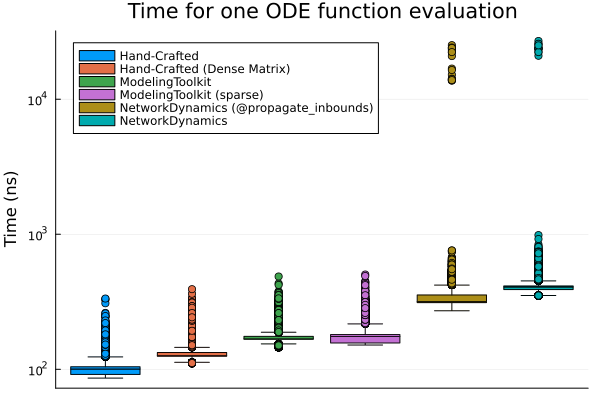

In [34]:
boxplot(b_sparse.times, 
    label="Hand-Crafted",
    ylabel="Time (ns)",
    title="Time for one ODE function evaluation",
    yticks=10 .^(1:6),
    xticks = [],
    yscale=:log10, 
    legend=:topleft)
boxplot!(b_dense.times, label="Hand-Crafted (Dense Matrix)")
boxplot!(b_mt.times, label="ModelingToolkit")
boxplot!(b_mt_2.times, label="ModelingToolkit (sparse)")
boxplot!(b_nd_ib.times, label="NetworkDynamics (@propagate_inbounds)")
boxplot!(b_nd.times, label="NetworkDynamics")